In [1]:
import numpy as np
import pickle
import os
import datetime
from itertools import chain
import matplotlib.pyplot as plt
from zhinst.core import ziDAQServer
from scipy.signal import periodogram, welch
from scipy.interpolate import interp1d
from lpsd import lpsd
import pandas as pd
import math

In [2]:
daq = ziDAQServer('10.209.64.46', 8004, 6)
daq.connectDevice("DEV6293", "PCIe")

In [3]:
now = datetime.date.today()  
ij = 1
time_meas = 60

timebase = daq.getDouble("/DEV6293/SYSTEM/PROPERTIES/TIMEBASE")

def timestamp_to_elapstime(timestamp, timebase):
    timestamp = timestamp - timestamp[0]
    elapstime = timestamp*timebase
    return elapstime

save_dir = r"C:\Users\SLAB2\Documents\Leo_Thesis_Data\interferometer_characterization\time_series_MFLI_2605"

# Prepare the Data structure array to write the data

Data = {'frequency':[],'x':[],'y':[], 'elapsedtime':[]}
# Data = {"elapsedtime": [], "pid_value": []}

for ii in range(time_meas):
    fp = os.path.join(save_dir, "%s.dat" % ij)
    file=open(fp,'rb')
    data_i_poll = pickle.load(file)
    
    Data['elapsedtime'].append(data_i_poll['timestamp'])
    # Data["pid_value"].append(data_i_poll["value"])
    Data['frequency'].append(data_i_poll['frequency'])
    Data['x'].append(data_i_poll['x'])
    Data['y'].append(data_i_poll['y'])
    file.close()
    ij=ij+1

    
Data['elapsedtime']=np.array(list(chain.from_iterable(Data['elapsedtime'])))
Data['x']=np.array(list(chain.from_iterable(Data['x'])))
Data['y']=np.array(list(chain.from_iterable(Data['y'])))
Data['frequency']=np.array(list(chain.from_iterable(Data['frequency'])))

Data['elapsedtime'] = timestamp_to_elapstime(Data['elapsedtime'] , timebase)
time0=Data['elapsedtime'][1]

# Data['pid_value']=np.array(list(chain.from_iterable(Data['pid_value'])))

xx = np.copy(Data["x"])
yy = np.copy(Data["y"])

In [4]:
print(timebase)

1.6666666666666667e-08


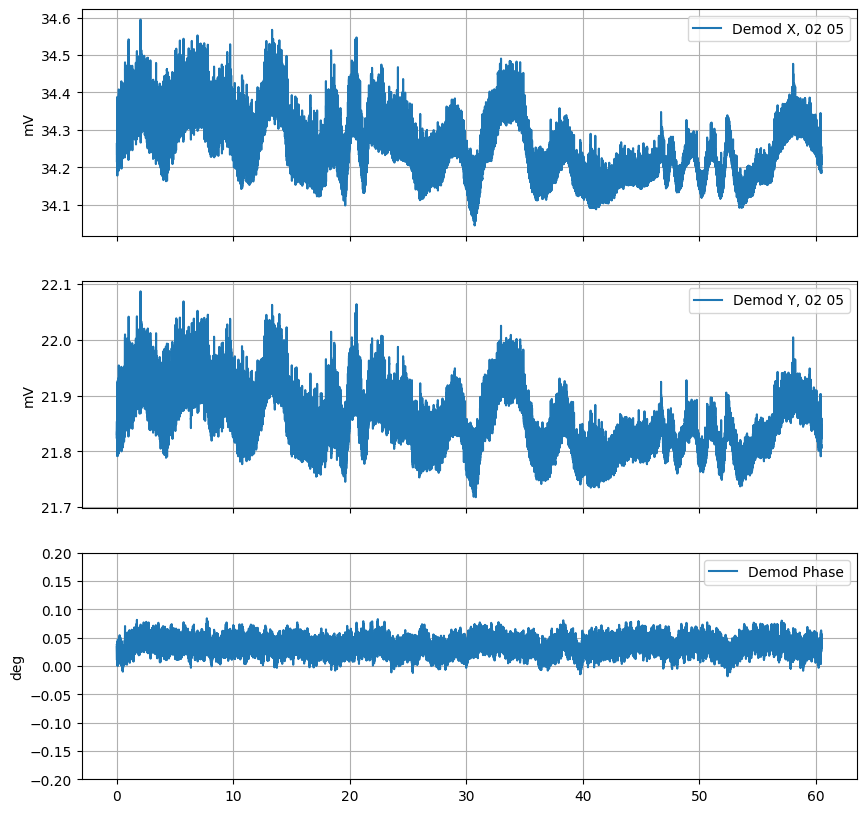

In [5]:
phase = np.atan2(yy, xx) * 180 / np.pi
setpoint = 32.5
phase_norm = phase - setpoint

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))
ax1.plot(Data["elapsedtime"], Data["x"]*1e3, label="Demod X, 02 05")
ax2.plot(Data["elapsedtime"], Data["y"]*1e3, label="Demod Y, 02 05")
ax1.set_ylabel("mV")
ax1.grid()
ax2.grid()
ax2.set_ylabel("mV")
# ax1.set_ylim(-22, -21)
# ax2.set_ylim(-6.2, -5.2)
ax1.legend()
ax2.legend()

ax3.grid()
ax3.plot(Data["elapsedtime"], phase_norm, label="Demod Phase")
ax3.set_ylim(-.2, .2)
ax3.set_ylabel("deg")
ax3.legend()

26786.0


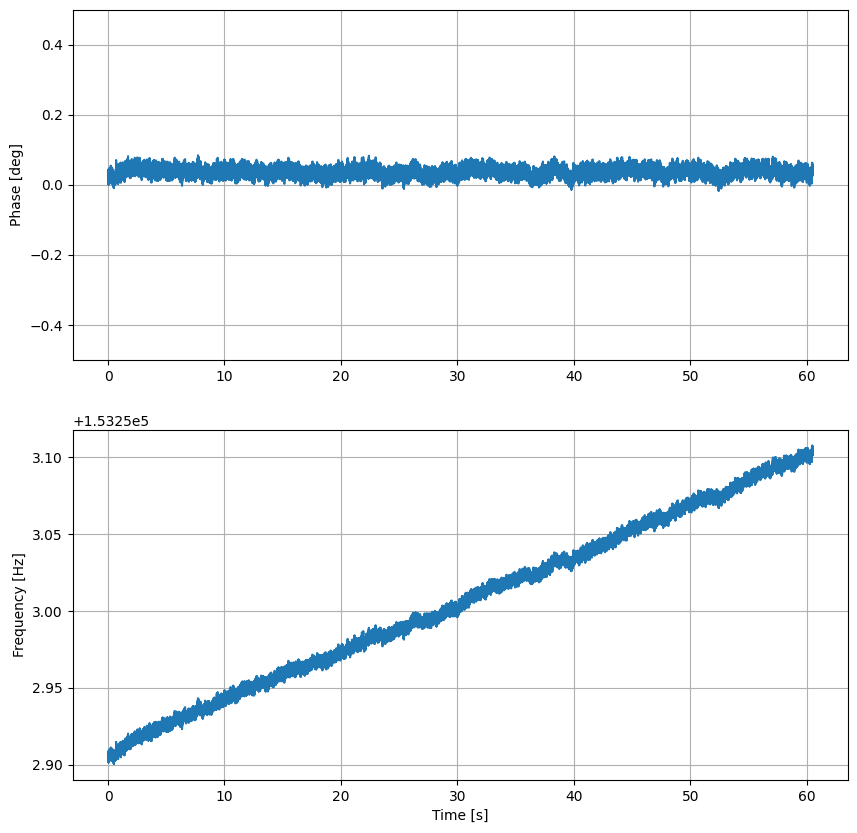

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, figsize=(10,10))

ax1.plot(Data['elapsedtime'], phase_norm, label="Phase [deg]")
ax1.set_ylabel("Phase [deg]")
ax1.grid(True)
ax1.set_ylim(-.5, .5)

ax2.plot(Data["elapsedtime"], Data["frequency"], label="Frequency [a.u.]", ms=0.5)
ax2.grid(True)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")

# Calculate sampling rate
rate = Data['elapsedtime'][1:-1]-Data['elapsedtime'][0:-2] # get difference

# rate = np.round(1/rate[0]) #[Hz]   
rate = np.round(1/rate[0])

Data['rate'] = rate # matches rate from lock-in data transfer window (104.6)
print(rate)  # sampling rate
# print(np.shape(Data["frequency"])[-1])  # number of data points

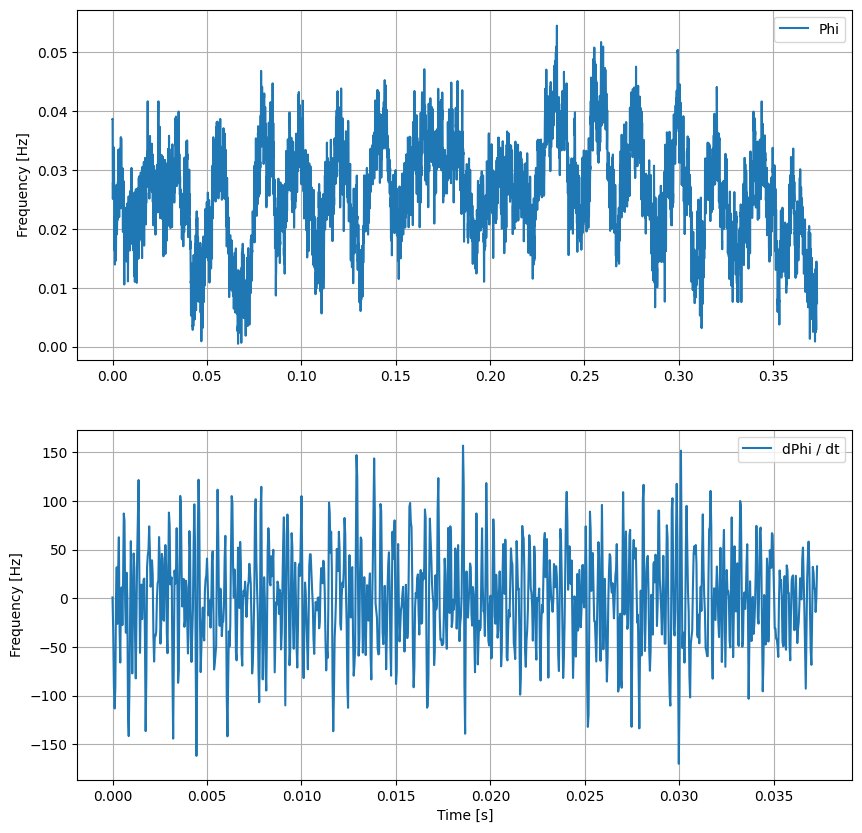

In [7]:
# transform to resonance frequency
freq_r_pll = np.copy(Data["frequency"]) # use PLL assumption that wR = w0

phase_diff = np.diff(phase_norm)

tau_r = 1.725 # in seconds
dt = 1 / rate
freq_r_fromPhase = (phase_norm / tau_r + np.gradient(phase_norm, dt)) / 4 / np.pi**2 # eq. 11 Besic
freq_r_fromBH = phase_norm[1:] / tau_r + phase_diff / dt #  

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))

ax1.plot(Data['elapsedtime'][:10000], phase_norm[:10000], label="Phi")
ax1.set_ylabel("Frequency [Hz]")
ax1.grid(True)
ax1.legend()

ax2.plot(Data["elapsedtime"][:1000], np.gradient(phase_norm[:1000], dt), label="dPhi / dt")
ax2.grid(True)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.legend()

In [8]:
# comparison of LPSD for different bin sizes
freq_oscillator = np.copy(Data["frequency"])

df = pd.DataFrame(freq_oscillator, columns=["signal"], index=Data["elapsedtime"])

spectrum_lpsd = lpsd(df, sample_rate=int(rate), min_segment_length=0.5*int(rate))
f_lpsd_10Hz, pxx_lpsd_10Hz = spectrum_lpsd.index.to_numpy(), np.multiply(spectrum_lpsd["psd"].to_numpy(), 0.5)

In [70]:
df_phase = pd.DataFrame(phase, columns=["signal"], index=Data["elapsedtime"])

spectrum_lpsd_phase = lpsd(df_phase, sample_rate=int(rate), min_segment_length=0.5*int(rate))
f_lpsd_10Hz_phase, pxx_lpsd_10Hz_phase = spectrum_lpsd_phase.index.to_numpy(), np.multiply(spectrum_lpsd_phase["psd"].to_numpy(), 0.5)

In [71]:
dir = r"C:\Users\SLAB2\Documents\Leo_Thesis_Data\interferometer_characterization\transfer_functions_zurich"
f_name = "250522_10HzPLL_PID_OpenLoop.txt"
fp = os.path.join(dir, f_name)
data_pid_test = np.loadtxt(fp, comments="%", delimiter=";", skiprows=5)

# Interpolation
interp_func_10Hz = interp1d(data_pid_test[:, 0], data_pid_test[:, 1] ** 2, kind='linear', bounds_error=False, fill_value="extrapolate")
interpolated_tf_pxx_ax_10Hz = interp_func_10Hz(f_lpsd_10Hz)

In [15]:
# noise spectra
t_r = 1.945 #s
k_p = 174.5 * 1e-3 * 360
f_pll = k_p / 2 / np.pi
w_pll = np.copy(k_p)
f_dm = 2.5e3
print(w_pll)

def h_demod(s, f_demod, order=4):
    w_dm = 2*np.pi * f_demod
    demod_out = (w_dm/(w_dm + s))**order
    return demod_out

s_in = np.copy(f_lpsd_10Hz)

h_thm_to_freq = w_pll / (w_pll * h_demod(s_in, f_dm, order=4) + s_in) * h_demod(s_in, f_dm, order=4) / t_r # thermo-mechanical noise to PID out, verified, matches eq. 89 Demir or equation A.13 Verhagen
h_dn_to_freq = h_thm_to_freq * (1 + t_r * s_in) # detection noise to PID out, same as freq but divide by tf of resonator, double-checked
h_rn_to_freq = -h_thm_to_freq / t_r  # resonance noise to PID out

kb = 1.380649e-23
m_eff = 3.56E-11  # density 3170, 50nm thick, 1mm long
dV_to_dm = 1.47e6

temp = 300 # in Kelvin
freq_resonance = 153.246 * 1e3 
qfactor = freq_resonance * t_r * np.pi
amp_drive_v = 40.8e-3 # demodulated rms amplitude is 22 mV uncertainty +- 5
amp_drive_m = amp_drive_v / dV_to_dm
dn_v = 7.8e-15 # V^2 / Hz

print(amp_drive_m)

s_thm_in = kb * temp * qfactor / (2 * np.pi**3 * m_eff * freq_resonance**3 * amp_drive_m**2) # double-checked, Demir alone eq. 71
s_thm_out = np.abs(h_thm_to_freq)**2 #* s_thm_in

print(s_thm_in)

s_dn_in = 7.8e-15 / dV_to_dm ** 2 # / amp_drive_m**2 # detection noise from volt to m to phase
s_dn_out = np.abs(h_dn_to_freq)**2 #* s_dn_in 

print(np.sqrt(s_dn_in))

s_th = 0  # thermal resonator noise, units m^2 / Hz 

62.82000000000001
2.775510204081633e-08
6.336952509350075e-07
6.008000589338672e-14


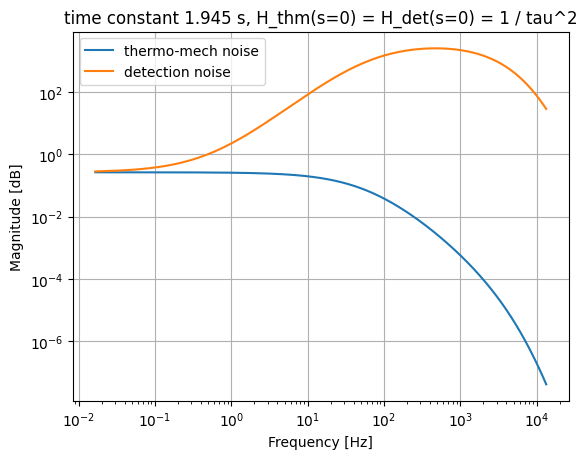

In [44]:
plt.plot(f_lpsd_10Hz, s_thm_out, label="thermo-mech noise")
plt.plot(f_lpsd_10Hz, s_dn_out, label="detection noise")
# plt.plot(f_lpsd_10Hz, s_thm_out + s_dn_out, label="combined")
plt.xscale("log")
plt.yscale("log")
plt.title("time constant 1.945 s, H_thm(s=0) = H_det(s=0) = 1 / tau^2")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.legend()

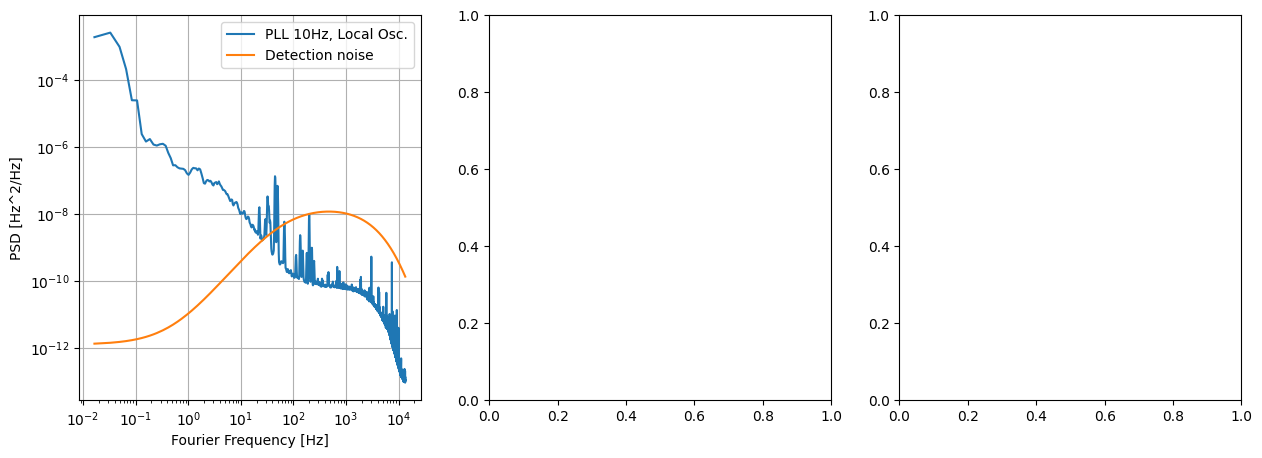

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3, sharey=False)

ax1.grid()
ax1.set_ylabel("PSD [Hz^2/Hz]")
ax1.set_xlabel("Fourier Frequency [Hz]")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.plot(f_lpsd_10Hz, pxx_lpsd_10Hz, label="PLL 10Hz, Local Osc.")
ax1.plot(f_lpsd_10Hz, s_dn_out, label="Detection noise")
# ax1.plot(f_lpsd_10Hz, (s_thm_out + s_dn_out) / freq_resonance**2, label="thm + det noise fractional")
ax1.legend()
# ax1.set_ylim(1e-13, 1e-2)

# ax2.grid()
# ax2.set_xlabel("Fourier Frequency [Hz]")
# ax2.set_xscale("log")
# ax2.set_yscale("log")
# ax2.plot(f_lpsd_10Hz_phase, pxx_lpsd_10Hz_phase, label="PLL 10Hz, Phase Demod")
# ax2.legend()
# ax2.set_ylim(1e-13, 1e-2)

# ax3.grid()
# ax3.set_xlabel("Fourier Frequency [Hz]")
# ax3.set_xscale("log")
# ax3.set_yscale("log")
# ax3.set_ylabel("dB")
# ax3.plot(data_pid_test[:, 0], data_pid_test[:, 1] ** 2, label="TF from Zurich for 10Hz from set-point \n to local oscillator")
# ax2.plot(f_lpsd_10Hz, pxx_lpsd_10Hz / interpolated_tf_pxx_ax_10Hz, label="PLL 10Hz, PSD freq / TF")
# ax3.legend()
# ax2.legend()

[0.00000000e+00 1.65223699e-02 3.30447398e-02 ... 1.33929670e+04
 1.33929835e+04 1.33930000e+04]


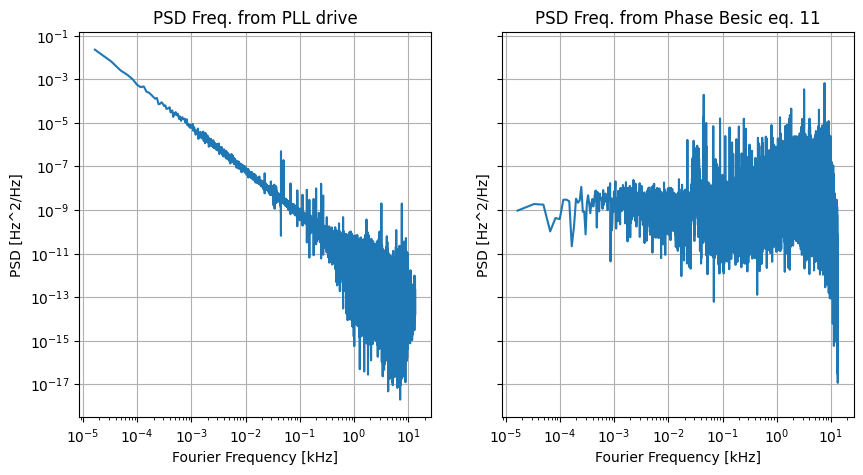

In [58]:
freqs, pxx_freq_pll = periodogram(freq_r_pll, fs=rate, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1) # standard values
_, pxx_freq_phase = periodogram(freq_r_fromPhase, fs=rate, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1) 

fig_test, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)

ax1.plot(freqs[1:] * 1e-3, pxx_freq_pll[1:])
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel("Fourier Frequency [kHz]")
ax1.set_ylabel("PSD [Hz^2/Hz]")
ax1.grid()

ax2.plot(freqs[1:] * 1e-3, pxx_freq_phase[1:])
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("Fourier Frequency [kHz]")
ax2.set_ylabel("PSD [Hz^2/Hz]")
ax2.grid()

ax1.set_title("PSD Freq. from PLL drive")
ax2.set_title("PSD Freq. from Phase Besic eq. 11")

print(freqs)

In [68]:
dir = r"C:\Users\SLAB2\Documents\Leo_Thesis_Data\interferometer_characterization\transfer_functions_zurich"
f_name = "250508_100Hz.txt"
fp = os.path.join(dir, f_name)
data_100Hz = np.loadtxt(fp, comments="%", delimiter=";", skiprows=5)

# data_dB = 10 * np.exp(data[:, 1])

In [53]:
data_10Hz = np.copy(data)

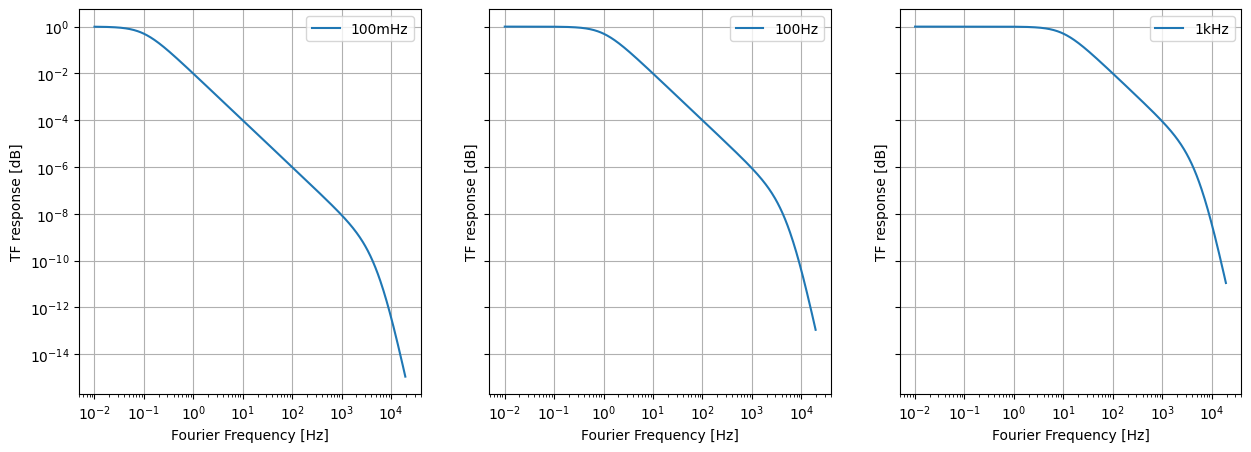

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))

ax1.plot(data_100mHz[:, 0], data_100mHz[:, 1] ** 2, label="100mHz")
ax1.legend()
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Fourier Frequency [Hz]")
ax1.set_ylabel("TF response [dB]")
ax1.grid()
# ax1.axvline(30.127, color="k")
# ax1.axhline(1e-5, color="k")

ax2.plot(data_1Hz[:, 0], data_1Hz[:, 1] ** 2, label="100Hz")
ax2.legend()
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Fourier Frequency [Hz]")
ax2.set_ylabel("TF response [dB]")
ax2.grid()

ax3.plot(data_10Hz[:, 0], data_10Hz[:, 1] ** 2, label="1kHz")
ax3.legend()
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Fourier Frequency [Hz]")
ax3.set_ylabel("TF response [dB]")
ax3.grid()

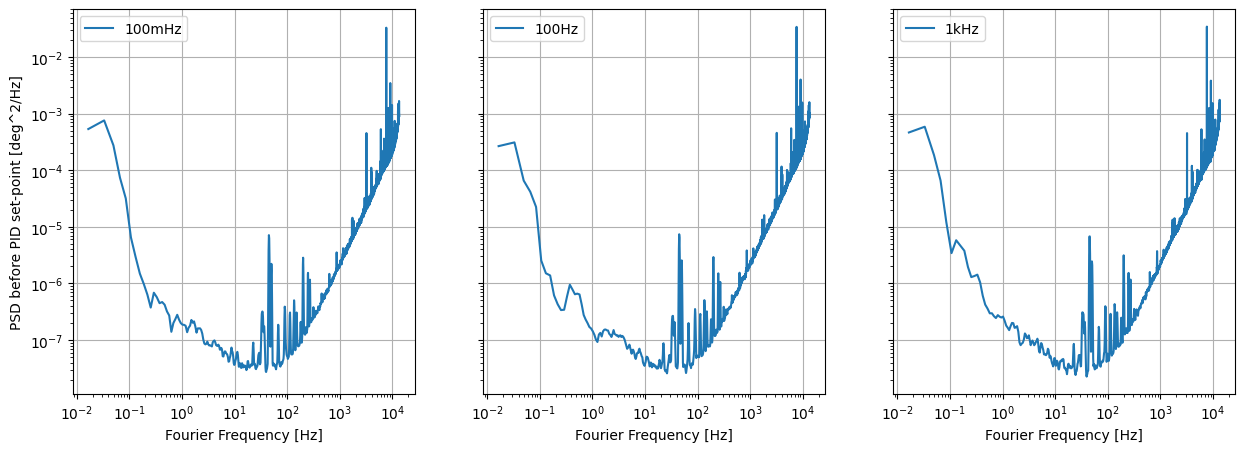

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))


# Interpolation
interp_func_100mHz = interp1d(data_100mHz[:, 0], data_100mHz[:, 1] ** 2, kind='linear', bounds_error=False, fill_value="extrapolate")
interpolated_tf_pxx_ax_100mHz = interp_func_100mHz(f_lpsd_100mHz)

interp_func_1Hz = interp1d(data_100Hz[:, 0], data_100Hz[:, 1] ** 2, kind='linear', bounds_error=False, fill_value="extrapolate")
interpolated_tf_pxx_ax_100Hz = interp_func_1Hz(f_lpsd_100Hz)

interp_func_10Hz = interp1d(data_1kHz[:, 0], data_1kHz[:, 1] ** 2, kind='linear', bounds_error=False, fill_value="extrapolate")
interpolated_tf_pxx_ax_1kHz = interp_func_10Hz(f_lpsd_1kHz)

ax1.plot(f_lpsd_100mHz, pxx_lpsd_100mHz / interpolated_tf_pxx_ax_100mHz, label="100mHz")
ax1.legend()
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Fourier Frequency [Hz]")
ax1.set_ylabel("PSD before PID set-point [deg^2/Hz]")
ax1.grid()

ax2.plot(f_lpsd_100Hz, pxx_lpsd_100Hz / interpolated_tf_pxx_ax_100Hz, label="100Hz")
ax2.legend()
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Fourier Frequency [Hz]")
ax2.grid()

ax3.plot(f_lpsd_1kHz, pxx_lpsd_1kHz / interpolated_tf_pxx_ax_1kHz, label="1kHz")
ax3.legend()
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Fourier Frequency [Hz]")
ax3.grid()